<a href="https://colab.research.google.com/github/sadeelmu/tngstage/blob/main/TNG_Task_1_BVEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulated base inference of SEEG signals using 2D VEP model

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp


import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

To make SBI work one must first install sbi and make sure everything is compatiable

In [2]:
!git clone https://github.com/ins-amu/BVEP.git

Cloning into 'BVEP'...
remote: Enumerating objects: 3211, done.
remote: Counting objects: 100% (2643/2643), done.
remote: Compressing objects: 100% (1376/1376), done.
remote: Total 3211 (delta 1284), reused 2579 (delta 1234), pack-reused 568 (from 1)
Receiving objects: 100% (3211/3211), 151.91 MiB | 21.14 MiB/s, done.
Resolving deltas: 100% (1557/1557), done.
Updating files: 100% (3913/3913), done.


In [3]:
!pip install sbi==0.24.0 torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.1/383.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 860.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━

In [4]:
import torch
import sbi
print(sbi.__version__)

0.24.0


In [6]:
#note: the sbi.inference does not exist anymore
#and sbi.utils.get_nn_models and sbi.utils.stimulations does not exist either

# posterior_nn was deprecated and removed. rather we use default NN from SNPE.

# sbi workflow:
# 1. Define simulator
# 2. Wrap simulater
# 3. Generate simulations
# 4. Use SNPE inference method
# 5. Train, then sample posterior
# 6. Plot

import torch
from sbi.inference import SNPE #See paper on (Training deep neural density estimators to identify mechanistic models of neural dynamics)
from sbi.simulators import linear_gaussian
from sbi.utils import BoxUniform
import sbi.utils as utils
from sbi.analysis import pairplot

# Define prior (2-dimensional uniform)
#prior = BoxUniform(low=torch.tensor([-2., -2.]), high=torch.tensor([2., 2.]))

# Parameters for linear_gaussian simulator
#likelihood_shift = torch.zeros(2)
#likelihood_cov = torch.eye(2)

# Define simulator as a lambda wrapping linear_gaussian with fixed params
#def simulator(theta):
#    return theta + torch.randn(1) * 0.1

# Simulate data
#num_simulations = 1000
#theta = prior.sample((num_simulations,))
# = torch.stack([simulator(t) for t in theta])

# Run inference
#inference = SNPE(prior=prior)  # Defaults to masked autoregressive flow (maf)
#density_estimator = inference.append_simulations(theta, x).train()
#posterior = inference.build_posterior(density_estimator)

# Sample from the posterior
#x_o = x[0]  # observation
#posterior_samples = posterior.sample((1000,), x=x_o)

# Plot results
#pairplot(posterior_samples, labels=["theta1", "theta2"])

In [7]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast

To get the BVEP_SME

In [8]:
import sys
sys.path.append('/content/BVEP/SBI')

In [9]:
from BVEP_SME import SME_labels, SEM_violinplot, plot_confusion_matrix, plot_zscore_shrinkage, plot_roc_curve, true_node_binary, estimated_node_binary, SME_accuracy

In [10]:
from sklearn.metrics import confusion_matrix

In [11]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [12]:
import warnings
warnings.simplefilter("ignore")

In [13]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [14]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v2.0.2
Running on torch: v2.5.1+cu124
Running on sbi: v0.24.0


In [15]:
Res_dir='Res_BVEP_ode_sbi_maf_sourcelevel_onset_patient1_savesim_v18_samplerejection'

### Constants

In [16]:
I1=3.1
eta_c=-2.05
delta_eta=1.0
prior_std =1.0
sd_thr=0.8

# Patient CJ

In [17]:
# Set cwd to the directory containing the data
cwd = '/content/BVEP/SBI'
cwd

'/content/BVEP/SBI'

## Structural Connectivity and Gain Matrices

In [18]:
weights_path = os.path.join('/content/BVEP/Optimization/sacess_VEP_models/benchmarks/python/ExperimentalData/connectivity', 'weights.txt')
weights = np.loadtxt(weights_path)

In [19]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [20]:
weights.min(), weights.max()

(np.float64(0.0), np.float64(1.0))

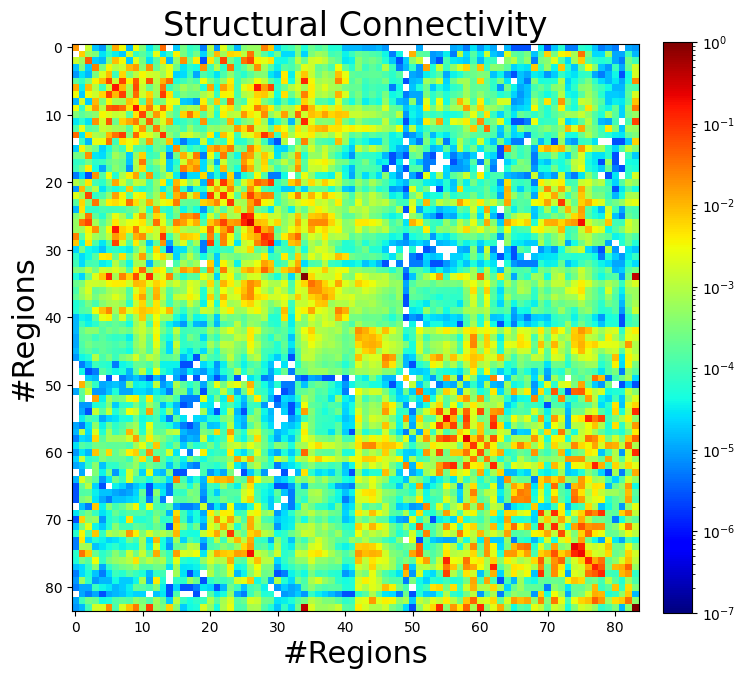

In [22]:
Res_dir = 'results'  # relative folder name inside cwd

results_path = os.path.join(cwd, Res_dir)
os.makedirs(results_path, exist_ok=True)

plt.figure(figsize=(8, 8))
norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights, norm=norm, cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Structural Connectivity', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)

plt.savefig(os.path.join(results_path, "SCMatrix.png"), dpi=800)
plt.savefig(os.path.join(results_path, "SCMatrix.svg"), dpi=800)
plt.show()


## ROIs chosen as Epileptogenic/propagation zones

In [23]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [24]:
#Here, confidential medical information
weights[np.ix_(pz_kplng_idx, ez_idx)] = 4.0
weights[np.ix_(pz_wplng_idx, ez_idx)] = 1.0

weights[np.diag_indices(weights.shape[0])] = 0

In [25]:
SC=weights
SC.shape

(84, 84)

### Simulator

In [26]:
from BVEP_Simulator import VEP2Dmodel

### some simulations for  sanity check

In [27]:
T = 14.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [28]:
nt=ts.shape[0]
nt

141

In [29]:
nn=SC.shape[0]
nn

84

In [30]:
ns=nn
ns

84

In [31]:
tau=10.
sigma=0*10e-1
constants = np.array([tau, sigma])
constants

array([10.,  0.])

In [32]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [33]:
K_true=1.

In [34]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [35]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [36]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 8.230263471603394


In [37]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.004596710205078125


In [38]:
X=Sim.reshape(nn, int(Sim.shape[0]/nn))
X.shape

(84, 141)

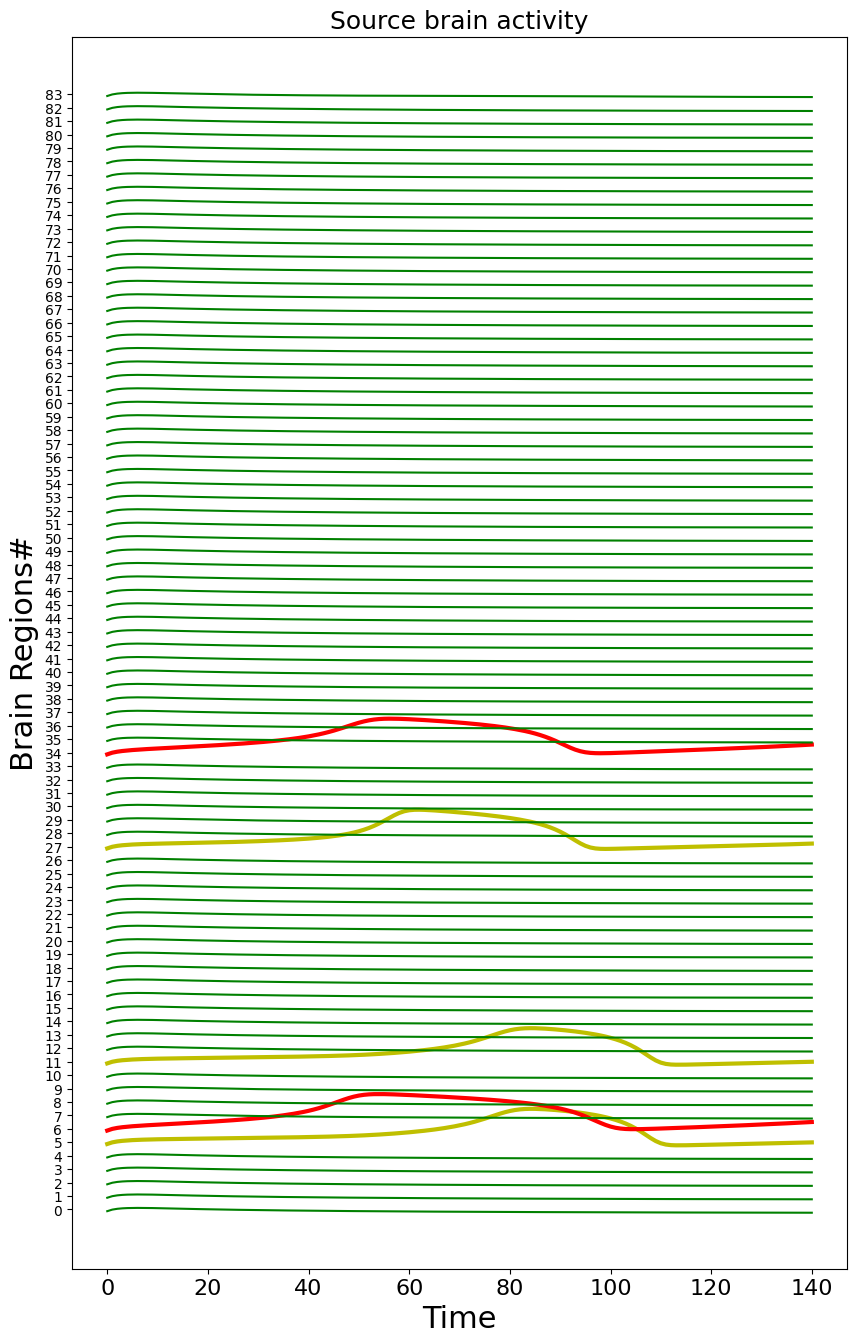

In [39]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=3)
    else:
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

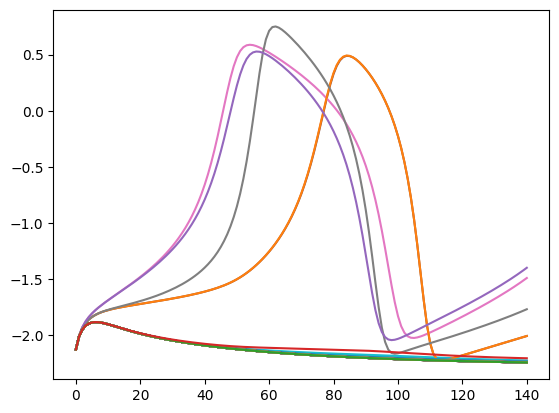

In [40]:
plt.plot(X.T);

### Data features

In [41]:
X.shape

(84, 141)

In [42]:
X_area = np.trapz(X, dx=0.0001)
X_area.shape

(84,)

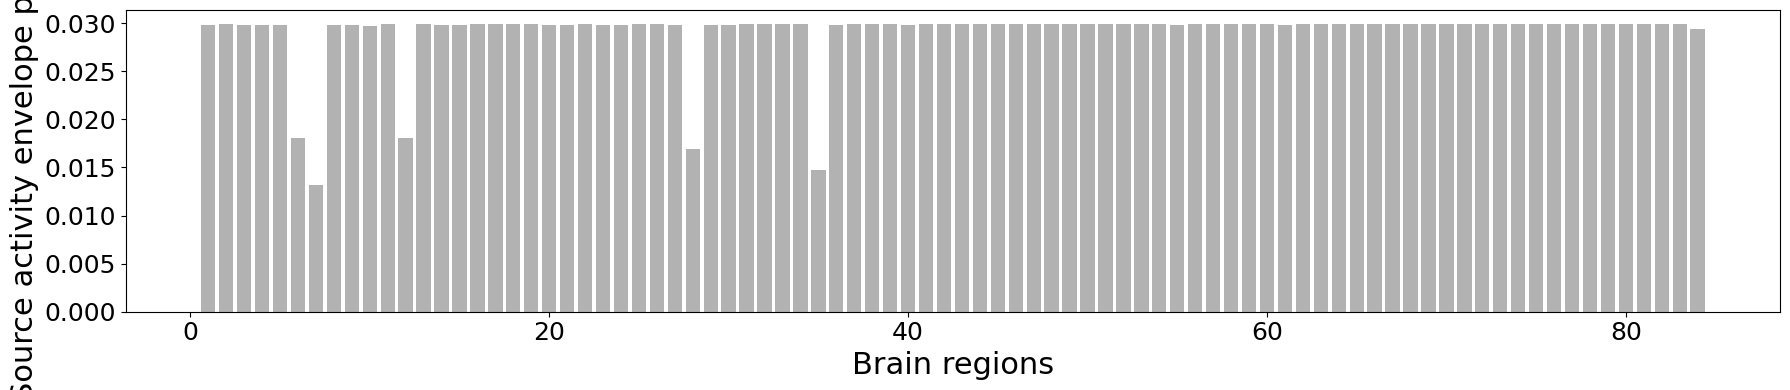

In [43]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,X_area.shape[0]+1), -X_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('Source activity envelope power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power.svg"), dpi=800)
plt.show()

In [44]:
X_pwr = np.sum((X*X), axis=1)
X_pwr_n = 1-(X_pwr/ X_pwr.max())

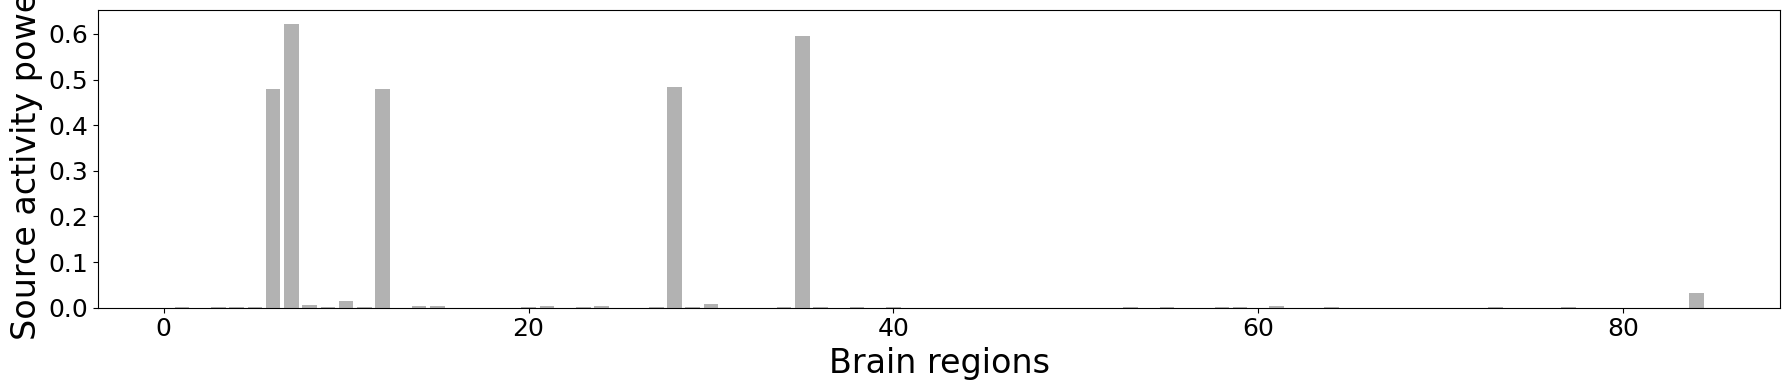

In [45]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,X_pwr.shape[0]+1), X_pwr_n, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=24)
plt.ylabel('Source activity power', fontsize=24)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power_normalize.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"Source_envelop_power_normalize.svg"), dpi=800)
plt.show()

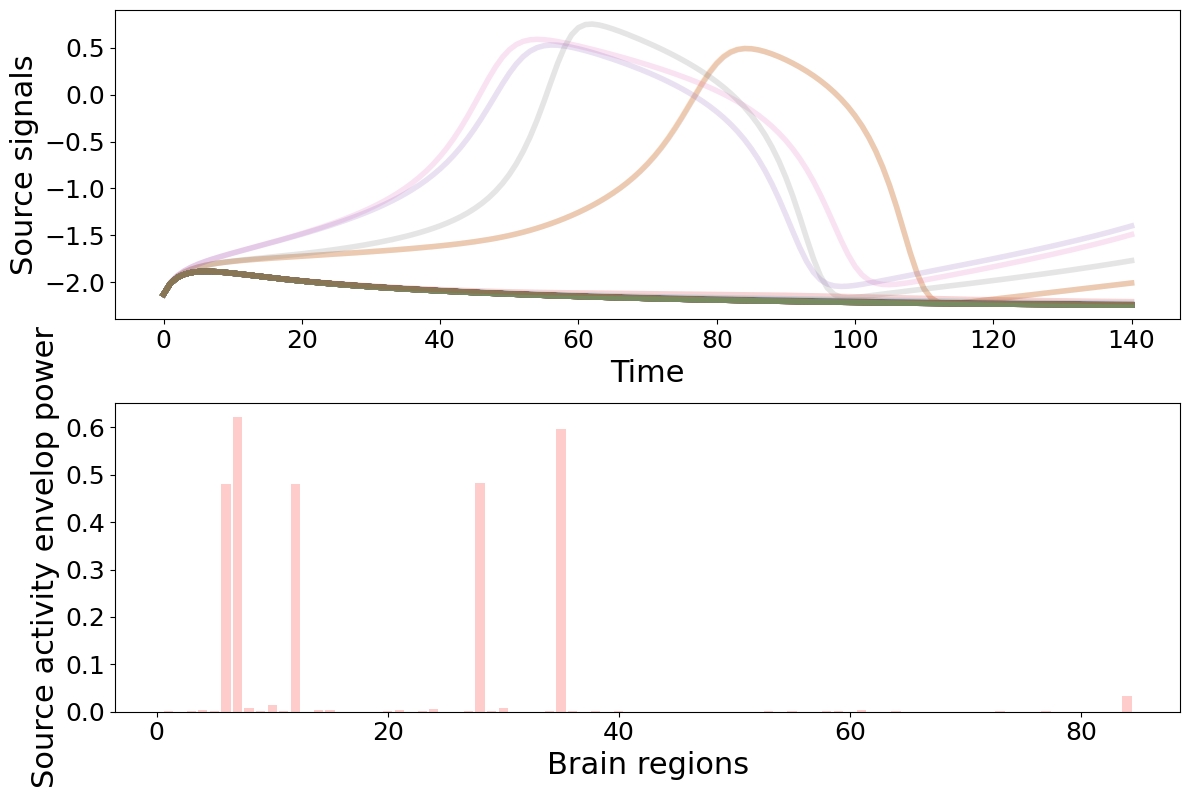

In [46]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(X.T, linewidth=4, alpha=0.2);
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(212)
plt.bar(np.arange(1,X_pwr_n.shape[0]+1), X_pwr_n, color='r', alpha=0.2)
#plt.bar(np.arange(1,Seeg_area.shape[0]+1), Seeg_area, color='black', alpha=0.3);
plt.xlabel('Brain regions', fontsize=22)
plt.ylabel('Source activity envelop power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.show()

In [47]:
from BVEP_stat_summary import calculate_summary_statistics_features

In [48]:
nn, ns, nt

(84, 84, 141)

In [49]:
_=calculate_summary_statistics_features(X.reshape(-1), nn, nt, dt, ts, features=['seizures_onset'])
num_features=_.shape[0]
print('feature shape:', num_features)

feature shape: 588


In [ ]:
num_params=nn+1
num_params

85

### 1. Simulator wrapper

In [87]:
def VEP2Dmodel_source_simulator_wrapper(params):

    # theta is a torch tensor, we convert to numpy so we can save them later
    params_np = theta.detach().cpu().numpy()

    # time step
    T = 14.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    # fixed parameters
    tau=10.
    sigma=0*10e-1
    constants = np.array([tau, sigma])

    nn=SC.shape[0]
    ns=nn
    nt=ts.shape[0]

    # initial conditions
    x_init=-2.5
    z_init=3.5
    init_conditions = np.array([x_init, z_init])

    Sim = VEP2Dmodel(params_np, constants, init_conditions, dt, ts, SC)  # numpy array output, shape (~11844,)

    #Source_signal=Sim.reshape(nn, int(Sim.shape[0]/nn))

    #summstats = torch.as_tensor(calculate_summary_statistics_features(Source_signal.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset']))

    return Sim


### 2. Prior over model parameters

In [76]:
nn+1

85

In [77]:
prior_min_eta=-5*np.ones(nn)
prior_min_K=0*np.ones(1)

prior_max_eta=-1*np.ones(nn)
prior_max_K=2*np.ones(1)

In [78]:
prior_min=np.append(prior_min_eta, prior_min_K)
prior_max=np.append(prior_max_eta, prior_max_K)

In [79]:
prior_min.shape, prior_max.shape

((85,), (85,))

In [80]:
prior = BoxUniform(low=torch.tensor(prior_min, dtype=torch.float32),
                   high=torch.tensor(prior_max, dtype=torch.float32))


In [81]:
prior.sample().shape, prior.batch_shape, prior.event_shape

(torch.Size([85]), torch.Size([]), torch.Size([85]))

### 3. Simulation and inference

In [82]:
num_sim=10000

In [83]:
# start_time = time.time()

# posterior = infer(VEP2Dmodel_source_simulator_wrapper, prior, method='SNPE',  num_simulations=10000, num_workers=1)

# print ("-"*60)
# print("--- %s seconds ---" % (time.time() - start_time))

In [84]:
mysavepath = os.path.join(Res_dir, 'output_sim/simulated_theta_x.npz')
mysavepath

'results/output_sim/simulated_theta_x.npz'

In [85]:
# def save_sims(simulator: Callable, prior, mysavepath, num_simulations: int):

#     simulator, prior = prepare_for_sbi(simulator, prior)

#     theta, x = simulate_for_sbi(
#         simulator=simulator,
#         proposal=prior,
#         num_simulations=num_simulations,
#         show_progress_bar=True,)

#     #print(theta,flush=True)
#     print( 'theta shape:',theta.shape,flush=True)
#     #print(x,flush=True)
#     print('data shape:', x.shape,flush=True)

#     np.savez(mysavepath,theta=theta,x=x)
#ABOVE IS. DEPRECATED

from typing import Callable


#NEW
def save_sims(simulator: Callable, prior, mysavepath: str, num_simulations: int):
    # Sample parameters from prior
    theta = prior.sample((num_simulations,))

    # Run simulator for each theta
    # If simulator returns a tensor, stack results
    x = torch.stack([simulator(t) for t in theta])

    print('theta shape:', theta.shape)
    print('data shape:', x.shape)

    # Save to npz file (convert tensors to numpy arrays)
    np.savez(mysavepath, theta=theta.numpy(), x=x.numpy())


In [88]:
# start_time = time.time()

# save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

# print ("-"*60)
# print("--- one sim took: %s seconds ---" % (time.time() - start_time))
#ABOVE IS DEPRECATED

#NEW
import time

start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

print("-" * 60)
print(f"--- one sim took: {time.time() - start_time} seconds ---")

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function concatenate>) found for signature:
 
 >>> concatenate(Tuple(array(float64, 1d, C), array(float64, 2d, C)))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'impl_np_concatenate': File: numba/np/arrayobj.py: Line 5884.
    With argument(s): '(Tuple(array(float64, 1d, C), array(float64, 2d, C)))':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<intrinsic np_concatenate>) found for signature:
    
    >>> np_concatenate(Tuple(array(float64, 1d, C), array(float64, 2d, C)), Literal[int](0))
    
   There are 2 candidate implementations:
         - Of which 2 did not match due to:
         Intrinsic in function 'np_concatenate': File: numba/np/arrayobj.py: Line 5867.
           With argument(s): '(Tuple(array(float64, 1d, C), array(float64, 2d, C)), int64)':
          Rejected as the implementation raised a specific error:
            NumbaTypeError: np.concatenate(): all the input arrays must have same number of dimensions
     raised from /usr/local/lib/python3.11/dist-packages/numba/core/typing/npydecl.py:513
   
   During: resolving callee type: Function(<intrinsic np_concatenate>)
   During: typing of call at /usr/local/lib/python3.11/dist-packages/numba/np/arrayobj.py (5888)
   
   
   File "../usr/local/lib/python3.11/dist-packages/numba/np/arrayobj.py", line 5888:
           def impl(arrays, axis=0):
               return np_concatenate(arrays, axis)
               ^

  raised from /usr/local/lib/python3.11/dist-packages/numba/core/typeinfer.py:1091

During: resolving callee type: Function(<built-in function concatenate>)
During: typing of call at /content/BVEP/SBI/BVEP_Simulator.py (42)


File "BVEP/SBI/BVEP_Simulator.py", line 42:
def epileptor2D_sde_fn(y, dt, sigma,  eta, tau, K, SC):
    <source elided>
    dz = (1.0/tau)*(4*(x - eta) - z - gx) + np.sqrt(dt)*sigma*np.random.randn()
    return np.concatenate((dx, dz))
    ^

During: resolving callee type: type(CPUDispatcher(<function epileptor2D_sde_fn at 0x7af8ae0ed9e0>))
During: typing of call at /content/BVEP/SBI/BVEP_Simulator.py (51)

During: resolving callee type: type(CPUDispatcher(<function epileptor2D_sde_fn at 0x7af8ae0ed9e0>))
During: typing of call at /content/BVEP/SBI/BVEP_Simulator.py (51)


File "BVEP/SBI/BVEP_Simulator.py", line 51:
def Integrator_Euler(y_init, nt, dt, sigma, eta, tau, K, SC):
    <source elided>
    for i in np.arange(nt):
            k1 = epileptor2D_sde_fn(y_next, dt, sigma, eta, tau, K, SC)
            ^

During: resolving callee type: type(CPUDispatcher(<function Integrator_Euler at 0x7af8ae0ee660>))
During: typing of call at /content/BVEP/SBI/BVEP_Simulator.py (80)

During: resolving callee type: type(CPUDispatcher(<function Integrator_Euler at 0x7af8ae0ee660>))
During: typing of call at /content/BVEP/SBI/BVEP_Simulator.py (80)


File "BVEP/SBI/BVEP_Simulator.py", line 80:
def VEP2Dmodel(params, constants, init_conditions, dt, ts, SC):
    <source elided>

    y_euler = Integrator_Euler(y_init, nt, dt, sigma, eta, tau, K, SC)
    ^


In [73]:
start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=1)

print ("-"*60)
print("--- one sim with JIT took: %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([1, 2])
data shape: torch.Size([1, 2])
------------------------------------------------------------
--- one sim with JIT took: 0.00606083869934082 seconds ---


In [63]:
start_time = time.time()

save_sims(VEP2Dmodel_source_simulator_wrapper, prior, mysavepath, num_simulations=num_sim)

print ("-"*60)
print("---all simulations took:  %s seconds ---" % (time.time() - start_time))

theta shape: torch.Size([10000, 2])
data shape: torch.Size([10000, 2])
------------------------------------------------------------
---all simulations took:  0.23726987838745117 seconds ---


### Load simulations and calculate features

In [ ]:
sim_deja=np.load(mysavepath)

In [ ]:
theta_deja=sim_deja['theta']
x_deja=sim_deja['x']

In [ ]:
print( 'theta shape:',theta_deja.shape,flush=True)
print('data shape:', x_deja.shape,flush=True)

theta shape: (10000, 2)
data shape: (10000, 2)


In [ ]:
x_deja_features=np.zeros((num_sim,num_features))
theta_deja_features=np.zeros((num_sim,num_params))

In [ ]:
print( 'theta shape:',theta_deja_features.shape,flush=True)
print('data frature shape:', x_deja_features.shape,flush=True)

theta shape: (10000, 85)
data frature shape: (10000, 588)


In [ ]:
start_time = time.time()

for i in range(num_sim):
    theta_deja_features[i,:]=theta_deja[i,:]
    x_deja_features[i,:]=calculate_summary_statistics_features(x_deja[i,:].reshape(-1), nn, nt, dt, ts, features=['seizures_onset'])

print ("-"*60)
print("---feature calculation took:  %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------
---feature calculation took:  23.67796778678894 seconds ---


In [ ]:
print( 'theta deja shape:',theta_deja_features.shape,flush=True)
print('data deja feature shape:', x_deja_features.shape,flush=True)

theta deja shape: (10000, 85)
data deja feature shape: (10000, 588)


In [ ]:
np.isnan(np.sum(x_deja_features))

False

In [ ]:
x = np.array(x_deja_features, dtype='float32')
x     = torch.as_tensor(x)

theta = np.array(theta_deja_features, dtype='float32')
theta = theta.reshape(theta.shape[0],num_params)
theta = torch.as_tensor(theta)

In [ ]:
print( 'theta shape:',theta.shape,flush=True)
print('data feature shape:', x.shape,flush=True)

theta shape: torch.Size([10000, 85])
data feature shape: torch.Size([10000, 588])


### Inference

In [ ]:
def myinfer_SNPE(prior, theta, x):

    inference = SNPE(prior, density_estimator='maf', device='cpu')
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(sample_with='rejection')

    return posterior

In [ ]:
start_time = time.time()

posterior = myinfer_SNPE(prior, theta, x)

print ("-"*60)
print("--- Training neural network took: %s seconds ---" % (time.time() - start_time))

 Neural network successfully converged after 560 epochs.------------------------------------------------------------
--- Training neural network took: 1172.9547379016876 seconds ---


### Data

In [ ]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

In [ ]:
obs_summary_statistics=calculate_summary_statistics_features(obs_source.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [ ]:
obs_source.shape, obs_summary_statistics.shape

((84, 141), (588,))

In [ ]:
y_obs=obs_source
y_obs.shape

(84, 141)

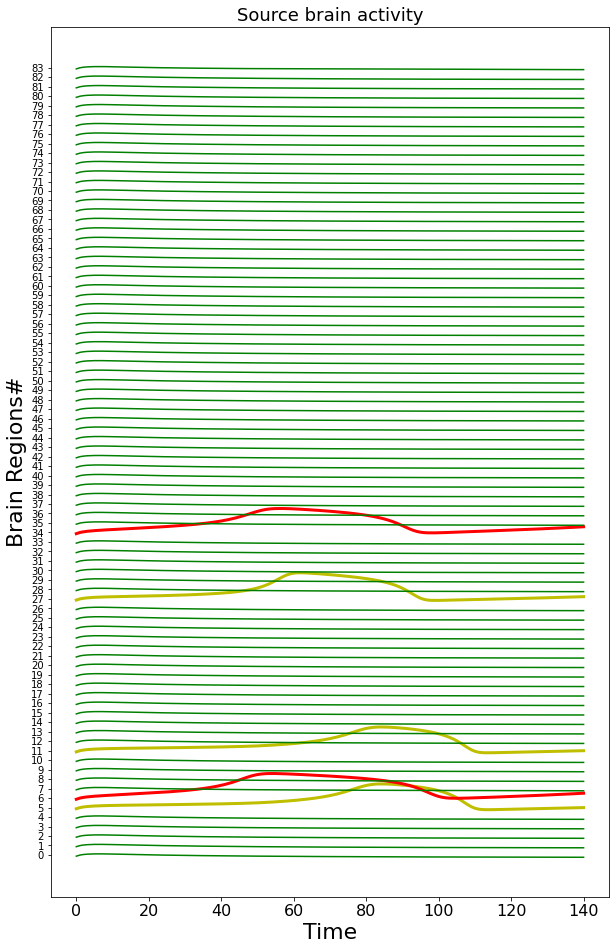

In [ ]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

### Posterior

In [ ]:
from sklearn.metrics import confusion_matrix
from BVEP_SME import SME_labels, SEM_violinplot, plot_confusion_matrix, plot_zscore_shrinkage, plot_roc_curve, true_node_binary, estimated_node_binary, SME_accuracy

In [ ]:
nodes=np.r_[0:nn]

In [ ]:
num_samples=200

In [ ]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 0.9366073608398438 seconds ---


In [ ]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [ ]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_posteriorsamples.npy') , posterior_samples)

In [ ]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [ ]:
K_posterior.mean(), K_posterior.std()

(1.2338698, 0.39454737)

In [ ]:
eta_c=-1.95
delta_eta=1.0

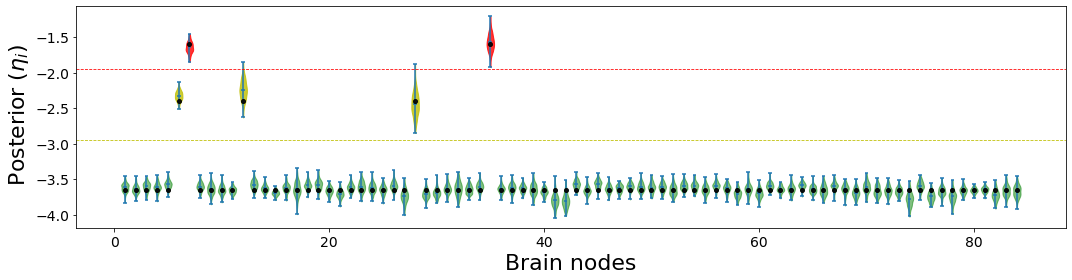

In [ ]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

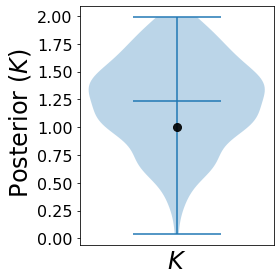

In [ ]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);
plt.xlabel(r'${K}$', fontsize=24);
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)

In [ ]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

In [ ]:
y_fit=yfit_source
y_fit.shape

(84, 141)

In [ ]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_patient1_y_fit.npy') , y_fit)

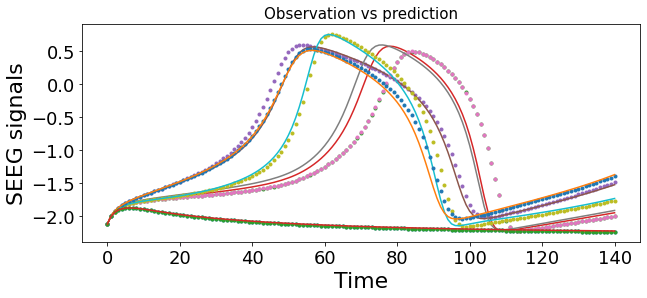

In [ ]:
Rois=np.array([1, 5, 6, 11, 27, 34, 50])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('SEEG signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

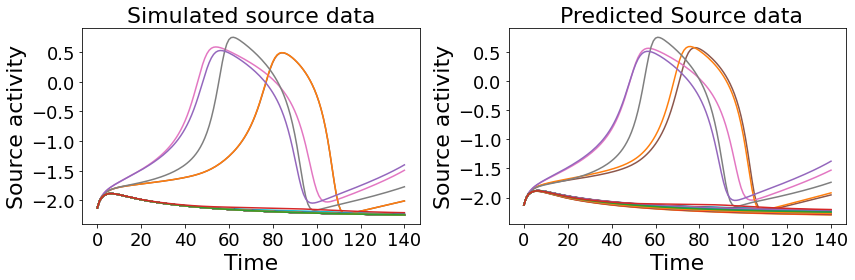

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

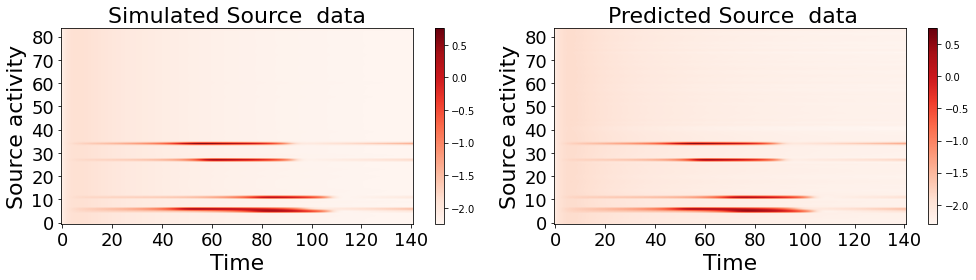

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source  data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source  data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [ ]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [ ]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 2  0  0]
 [ 0  3  0]
 [ 0  0 79]]


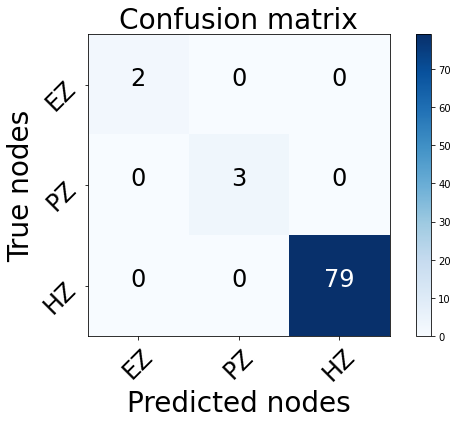

In [ ]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [ ]:
np.sum(np.std(eta_posterior, axis=0))

5.674836

In [ ]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [ ]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [ ]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [ ]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

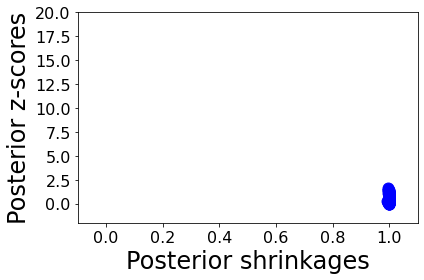

In [ ]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(3.288475561141966, 0.052370699609949056)

In [ ]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(190.04820562280545, 0.056645614711808824)

In [ ]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

In [ ]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [ ]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [ ]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [ ]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [ ]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

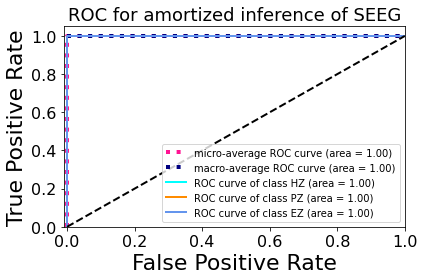

In [ ]:
# Plot all ROC curves
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
lw=2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [ ]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [ ]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [ ]:
roc_auc["micro"], roc_auc["macro"]

(1.0, 1.0)

### Another Data set

In [ ]:
hz_val=-3.65
pz_val=-2.5
ez_val=-1.7


ez_idx = np.array([7, 29],  dtype=np.int32)
pz_wplng_idx = np.array([6, 9, 28], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [ ]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [ ]:
K_true=1.

In [ ]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [ ]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [ ]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

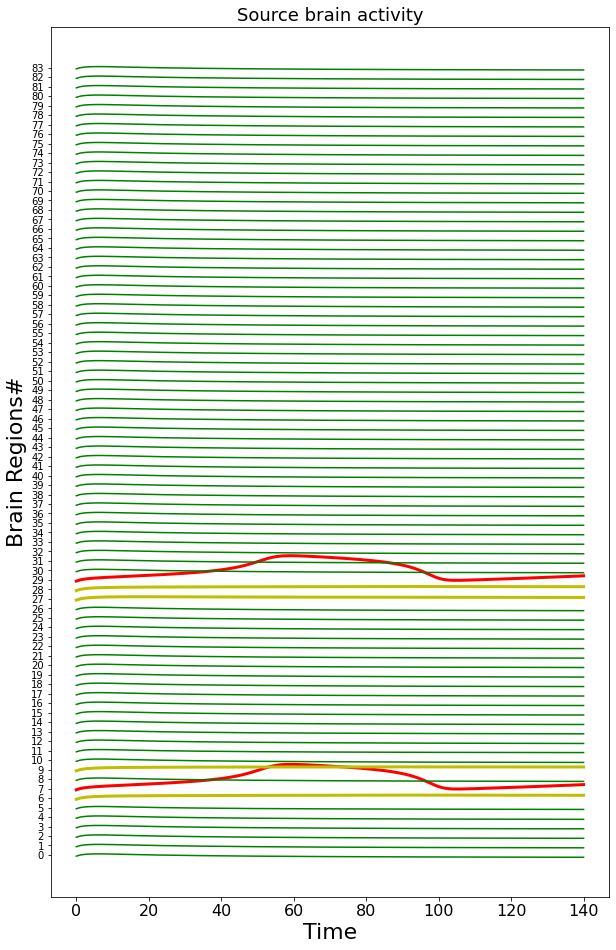

In [ ]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
obs_summary_statistics=calculate_summary_statistics_features(obs_source.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [ ]:
obs_source.shape, obs_summary_statistics.shape

((84, 141), (588,))

In [ ]:
y_obs=obs_source
y_obs.shape

(84, 141)

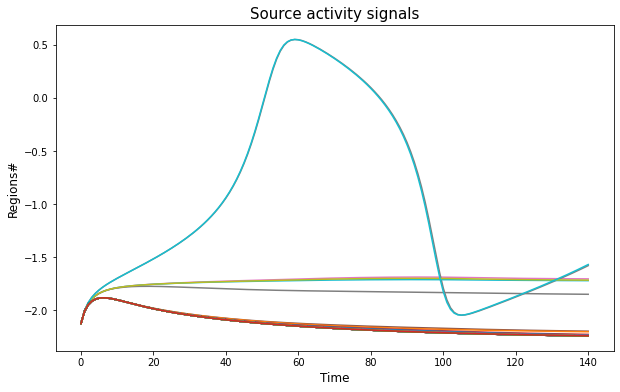

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(obs_source.T)
plt.title("Source activity signals",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Regions#',fontsize=12)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_seeg_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_seeg_K_"+str(K_true)+".svg"), dpi=800)

### Posterior

In [ ]:
nodes=np.r_[0:nn]

In [ ]:
num_samples=200

In [ ]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 0.8163886070251465 seconds ---


In [ ]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [ ]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs2_patient1_posteriorsamples.npy') , posterior_samples)

In [ ]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [ ]:
K_posterior.mean(), K_posterior.std()

(1.278067, 0.37699935)

In [ ]:
eta_c=-1.95
delta_eta=1.0

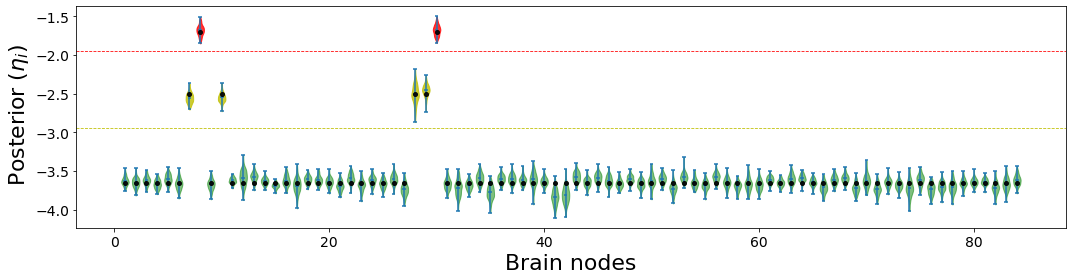

In [ ]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

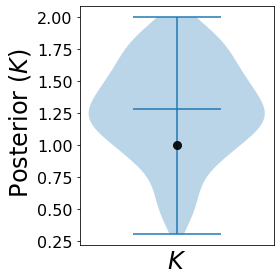

In [ ]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);
plt.xlabel(r'${K}$', fontsize=24);
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)

In [ ]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))


In [ ]:
y_fit=yfit_source
y_fit.shape

(84, 141)

In [ ]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs2_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs2_patient1_y_fit.npy') , y_fit)

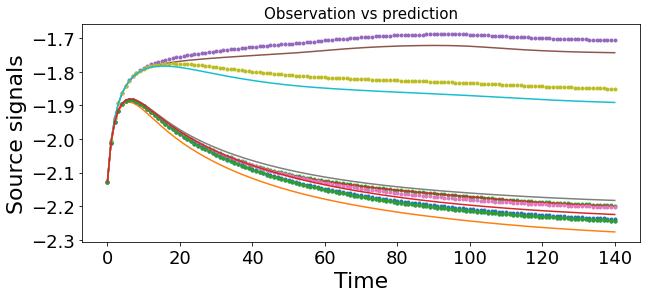

In [ ]:
Rois=np.array([1, 5, 6, 11, 27, 34, 50])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

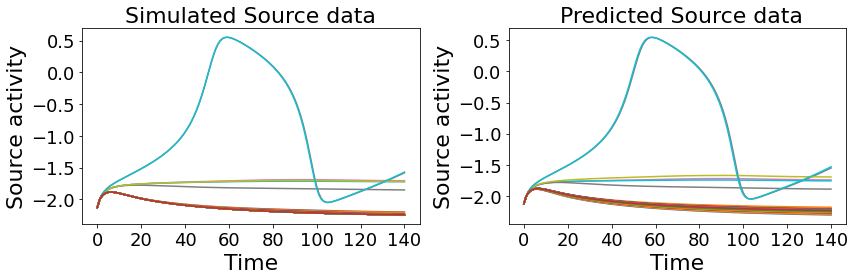

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs2_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs2_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

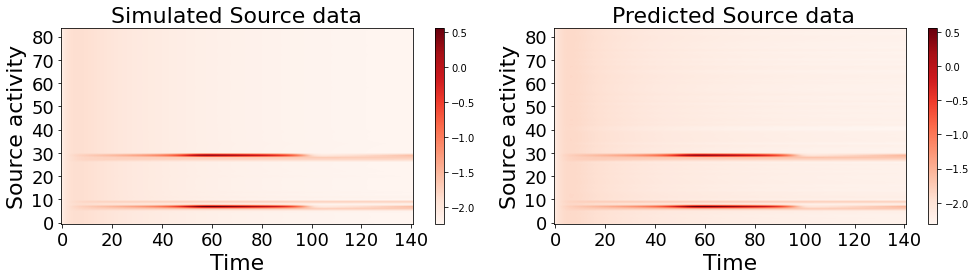

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs2_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs2_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [ ]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [ ]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 2  0  0]
 [ 0  4  0]
 [ 0  0 78]]


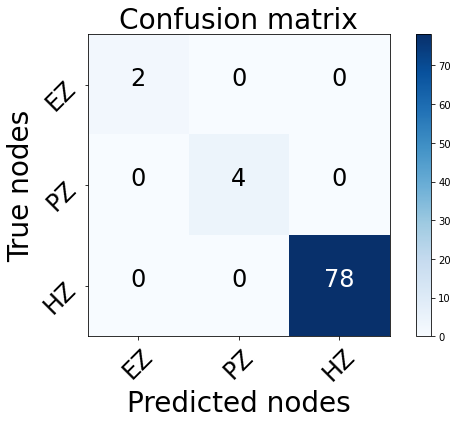

In [ ]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [ ]:
np.sum(np.std(eta_posterior, axis=0))

5.602771

In [ ]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [ ]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [ ]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [ ]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

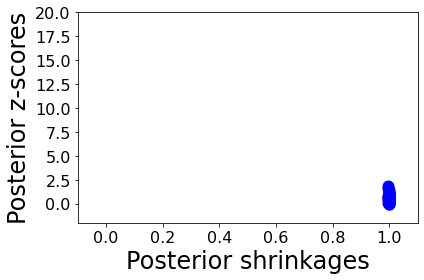

In [ ]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs2_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(3.4546746253967284, 0.05229975669106489)

In [ ]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(142.61193859049118, 0.018520514139508316)

In [ ]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

In [ ]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [ ]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [ ]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [ ]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [ ]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

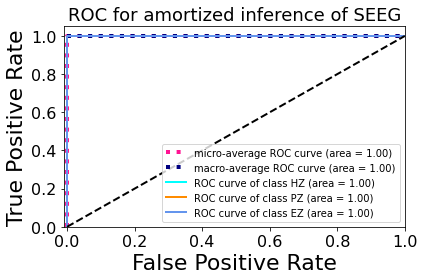

In [ ]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs2_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [ ]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [ ]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [ ]:
roc_auc["micro"], roc_auc["macro"]

(1.0, 1.0)

### Another Data set

In [ ]:
hz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34, 18, 45, 67, 81],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

In [ ]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [ ]:
K_true=1.

In [ ]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [ ]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [ ]:
obs_source =VEP2Dmodel(params_true, constants, init_conditions, dt, ts, SC)
obs_source=obs_source.reshape(nn, int(obs_source.shape[0]/nn))

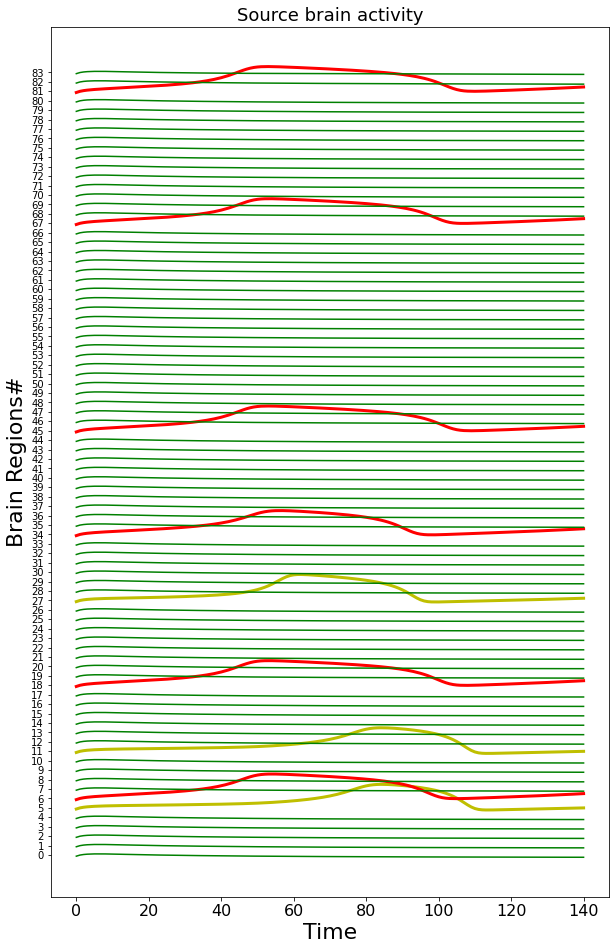

In [ ]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(obs_source[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(obs_source[i,:]+i, 'y', lw=3)
    else:
          plt.plot(obs_source[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_source_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_source_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
obs_summary_statistics=calculate_summary_statistics_features(obs_source.reshape(-1),  nn, nt, dt, ts, features=['seizures_onset'])

In [ ]:
obs_source.shape, obs_summary_statistics.shape

((84, 141), (588,))

In [ ]:
y_obs=obs_source
y_obs.shape

(84, 141)

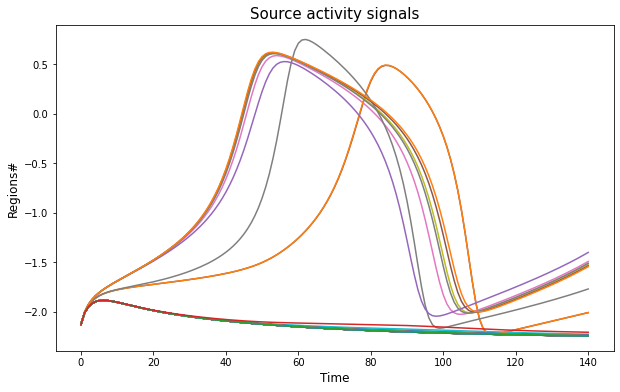

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(obs_source.T)
plt.title("Source activity signals",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Regions#',fontsize=12)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_seeg_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_seeg_K_"+str(K_true)+".svg"), dpi=800)

### Posterior

In [ ]:
nodes=np.r_[0:nn]

In [ ]:
num_samples=200

In [ ]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), obs_summary_statistics).numpy()

print ("-"*60)
print("--- sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

------------------------------------------------------------
--- sampling took: 0.9321682453155518 seconds ---


In [ ]:
posterior_samples.shape, params_true.shape

((200, 85), (85,))

In [ ]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs3_patient1_posteriorsamples.npy') , posterior_samples)

In [ ]:
eta_posterior=posterior_samples[:,:-1]
K_posterior=posterior_samples[:,-1]

In [ ]:
K_posterior.mean(), K_posterior.std()

(1.2544456, 0.36598346)

In [ ]:
eta_c=-1.95
delta_eta=1.0

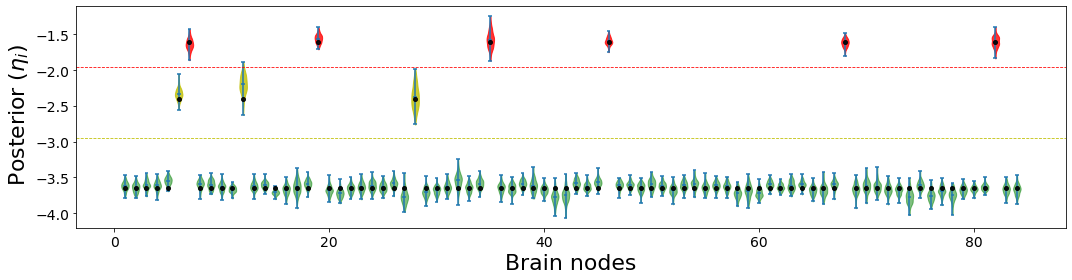

In [ ]:
plt.figure(figsize=(15,4))
SEM_violinplot(nn, eta_true, ez_idx, pz_idx, eta_posterior, eta_c, delta_eta )
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredExcitability_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredExcitability_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

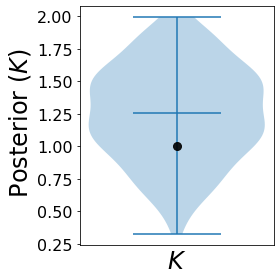

In [ ]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(K_posterior, widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=24);
plt.xlabel(r'${K}$', fontsize=24);
plt.yticks(fontsize=16)
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredCoupling_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_InferredCoupling_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
estimated_posterior=np.percentile(posterior_samples, [50], axis=0).reshape(-1)

In [ ]:
y_fit_source =VEP2Dmodel(estimated_posterior, constants, init_conditions, dt, ts, SC)

yfit_source=y_fit_source.reshape(nn, int(y_fit_source.shape[0]/nn))

In [ ]:
y_fit=yfit_source
y_fit.shape

(84, 141)

In [ ]:
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs3_patient1_y_obs.npy') , y_obs)
np.save(os.path.join(cwd+'/'+str(Res_dir), 'BVEP_ode_sbi_sourcelevel_obs3_patient1_y_obs.npy') , y_fit)

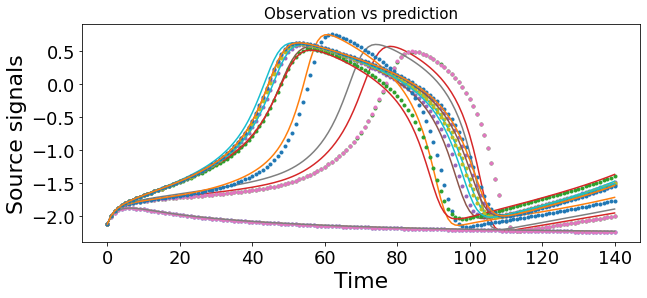

In [ ]:
Rois=np.array([1, 5, 6, 11,18,  27, 34, 45, 50, 67, 81])

plt.figure(figsize=(10,4))
for roi in Rois:
    plt.plot(y_obs.T[:,roi], '.')
    plt.plot(y_fit.T[:,roi] )
plt.title("Observation vs prediction",fontsize=15)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source signals', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.show()

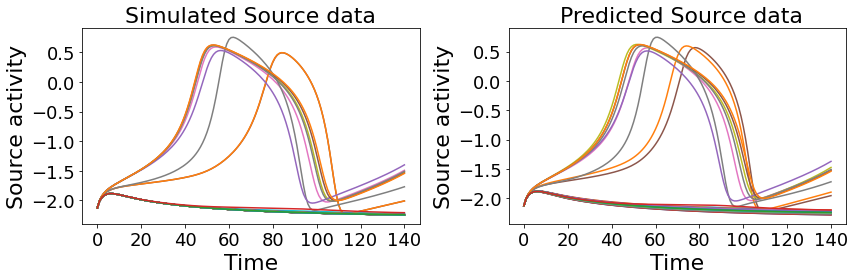

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(121);
plt.plot(y_obs.T)
plt.title("Simulated Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.plot(y_fit.T)
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs3_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_FittedBVEP_ode_obs3_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

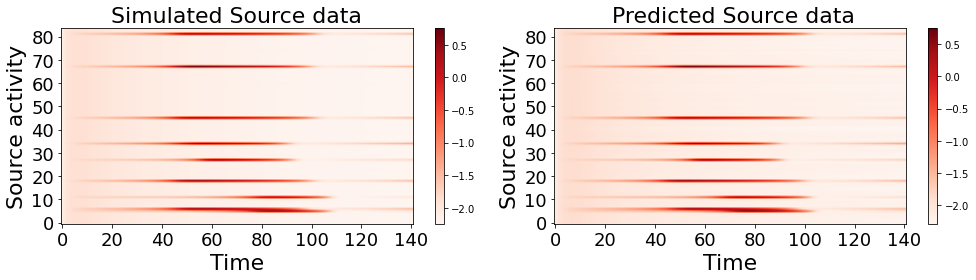

In [ ]:
plt.figure(figsize=(14, 4))
plt.subplot(121);
plt.imshow(y_obs, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title("Simulated Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.subplot(122)
plt.imshow(y_fit, aspect='auto', interpolation='bilinear',  origin='lower', cmap='Reds')
plt.title(" Predicted Source data", fontsize=22)
plt.xlabel('Time', fontsize=22)
plt.ylabel('Source activity', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.colorbar();

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs3_observation_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_ImshowFittedBVEP_ode_obs3_observation_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
eta_true.shape, eta_posterior.shape

((84,), (200, 84))

In [ ]:
true_labels_nodes,est_labels_nodes =SME_labels(eta_true, eta_posterior.transpose(), eta_c, delta_eta)

In [ ]:
Confusion_matrix_values= confusion_matrix(true_labels_nodes, est_labels_nodes, labels=["EZ", "PZ", "HZ"])
print('Confusion_matrix_values= \n', Confusion_matrix_values)

Confusion_matrix_values= 
 [[ 6  0  0]
 [ 0  3  0]
 [ 0  0 75]]


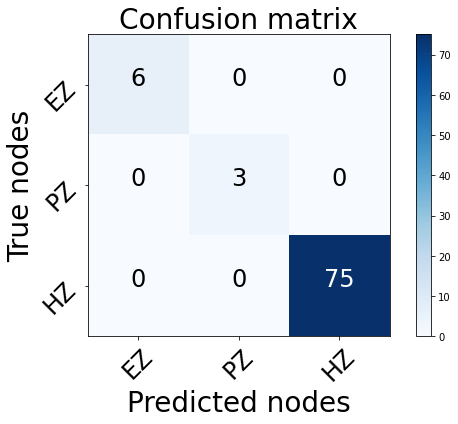

In [ ]:
plt.figure(figsize=(8, 6))
plot_confusion_matrix(Confusion_matrix_values, ["EZ", "PZ", "HZ"])
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_ConfusionMatrix_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_ConfusionMatrix_K_"+str(K_true)+".svg"), dpi=800)
plt.tight_layout()
plt.show()

In [ ]:
np.sum(np.std(eta_posterior, axis=0))

5.6958723

In [ ]:
from report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage

In [ ]:
eta_est_mu=np.mean(eta_posterior, axis=0)
eta_est_std=np.std(eta_posterior, axis=0)

In [ ]:
b=-7
a=-1
prior_std =np.sqrt((1/12)*(b-a)**2)

In [ ]:
def plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std):
    z_score_eta=z_score(eta_true, eta_est_mu, eta_est_std)
    colors= np.random.rand(z_score_eta.shape[0])
    plt.scatter(shrinkage([prior_std]*nodes.shape[0], eta_est_std), z_score_eta ,s=120, c='blue')
    plt.xlabel("Posterior shrinkages", fontsize=24)
    plt.ylabel("Posterior z-scores", fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

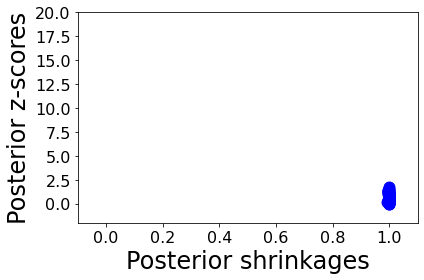

In [ ]:
plot_zscore_shrinkage(nodes, eta_true, eta_est_mu, eta_est_std, prior_std)
plt.axis((-.1,1.1,-2,20))
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_zscore_shrinkage_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"SBI_BVEP_ode_obs3_zscore_shrinkage_K_"+str(K_true)+".svg"), dpi=800)
plt.show()

In [ ]:
Err(eta_true, eta_est_mu), RMSE(eta_true, eta_est_mu)

(3.5299839496612533, 0.05441769652116261)

In [ ]:
Err(y_obs, y_fit), RMSE(y_obs, y_fit)

(211.27823160995757, 0.061408253016896605)

In [ ]:
shrinkage([prior_std]*nodes.shape[0], eta_est_std).shape

(84,)

In [ ]:
n_classes=3
node_classes=['HZ', 'PZ', 'EZ']

In [ ]:
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [ ]:
true_nodes=true_node_binary(true_labels_nodes)
estimated_nodes=estimated_node_binary(est_labels_nodes)

In [ ]:
y_true=label_binarize(true_nodes, classes=[0, 1, 2])
y_pred=label_binarize(estimated_nodes, classes=[0, 1, 2])

In [ ]:
y_true.shape, y_pred.shape

((84, 3), (84, 3))

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

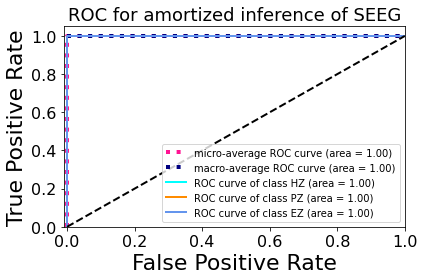

In [ ]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class '+ str(node_classes[i])+' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC for amortized inference of SEEG', fontsize=18)
plt.legend(loc="lower right")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"ROC_obs3_K_"+str(K_true)+".png"), dpi=800)
plt.show()

In [ ]:
fpr

{0: array([0., 0., 1.]),
 1: array([0., 0., 1.]),
 2: array([0., 0., 1.]),
 'micro': array([0., 0., 1.]),
 'macro': array([0., 1.])}

In [ ]:
tpr

{0: array([0., 1., 1.]),
 1: array([0., 1., 1.]),
 2: array([0., 1., 1.]),
 'micro': array([0., 1., 1.]),
 'macro': array([1., 1.])}

In [ ]:
roc_auc["micro"], roc_auc["macro"]

(1.0, 1.0)